### Classifying Community Areas by Violent Crime Percentage

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.target import BalancedBinningReference, ClassBalance, FeatureCorrelation
from yellowbrick.classifier import ClassificationReport

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, SMOTENC
from collections import Counter

In [3]:
total_df = pd.read_csv('/Users/Emi/Downloads/merged_df_pop.csv')

### Inspecting & Transforming Data

In [4]:
total_df.head()

,Community Area,Month,Violent Crimes,Total Crimes,Units,Grocery_Store_Count,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,...,PER CAPITA INCOME,HARDSHIP INDEX,COMMUNITY,TOTAL POPULATION,geometry,Area_sqm,Area_sqkm,Population Density (people/sqkm),Violent Crimes per Capita,Crimes per Capita
0,1.0,2003-01,141,595,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.273900,9.595536
1,1.0,2003-02,136,515,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.193265,8.305380
2,1.0,2003-03,173,669,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,2.789963,10.788930
3,1.0,2003-04,193,670,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,3.112502,10.805057
4,1.0,2003-05,201,769,1124.0,13.0,7.7,23.6,8.7,18.2,...,23939,39.0,ROGERS PARK,62008,MULTIPOLYGON (((-9757660.52852648 5160704.7461...,8.631616e+06,8.631616,7183.822617,3.241517,12.401626


In [5]:
total_df = total_df[total_df['Month'] >= '2017-11']

total_df['Units per Capita'] = (total_df['Units'] / total_df['TOTAL POPULATION']) * 1000

total_df['Percent Violent Crimes'] = (total_df['Violent Crimes'] / total_df['Total Crimes'])
total_df['Percent Violent Crimes'].describe()

count    5765.000000
mean        0.304469
std         0.076434
min         0.019608
25%         0.251613
50%         0.308411
75%         0.358491
max         0.600000
Name: Percent Violent Crimes, dtype: float64

### Creating Classes

In [6]:
def create_classes(data, variable):
    #p25 = np.percentile(data['Percent Violent Crimes'], 25)
    #p50 = np.percentile(total_df['Percent Violent Crimes'], 50)
    p75 = np.percentile(total_df['Percent Violent Crimes'], 75)
    
    classes = np.select(
            [total_df['Percent Violent Crimes'] >= p75, total_df['Percent Violent Crimes'] < p75],
            ['Above 75th Percentile', 'Below 75th Percentile']
        )

    return classes

# Create classes for your variable
total_df['Binary Target 75th'] = create_classes(total_df, 'Percent Violent Crimes')

total_df['Binary Target 75th'].value_counts()

Below 75th Percentile    4323
Above 75th Percentile    1442
Name: Binary Target 75th, dtype: int64

In [7]:
def categorize_crimes(Percent_Violent_Crimes):
    if Percent_Violent_Crimes >= 0.279552:
        return '>0.28%'
    elif Percent_Violent_Crimes < 0.279552:
        return '<0.28%'

total_df['Binary Target Mean'] = total_df['Percent Violent Crimes'].apply(categorize_crimes)

total_df['Binary Target Mean'].value_counts()

>0.28%    3650
<0.28%    2115
Name: Binary Target Mean, dtype: int64

### Additional Data Cleaning & Transformation

In [8]:
total_df.rename(columns={'Month':'Date'},inplace=True)

total_df['year'] = total_df['Date'].str.slice(0, 4)
total_df['Month'] = total_df['Date'].str.slice(-2)

total_df.columns

Index(['Community Area', 'Date', 'Violent Crimes', 'Total Crimes', 'Units',
       'Grocery_Store_Count', 'PERCENT OF HOUSING CROWDED',
       'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
       'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
       'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
       'HARDSHIP INDEX', 'COMMUNITY', 'TOTAL POPULATION', 'geometry',
       'Area_sqm', 'Area_sqkm', 'Population Density (people/sqkm)',
       'Violent Crimes per Capita', 'Crimes per Capita', 'Units per Capita',
       'Percent Violent Crimes', 'Binary Target 75th', 'Binary Target Mean',
       'year', 'Month'],
      dtype='object')

In [9]:
total_df['Month'] = total_df['Month'].astype('int')

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
#imputer.fit(total_df[['Grocery_Store_Count']])
#total_df['Grocery_Store_Count'] = imputer.transform(total_df[['Grocery_Store_Count']])

imputer.fit(total_df[['Units']])
total_df['Units'] = imputer.transform(total_df[['Units']])
total_df['Units per Capita'] = imputer.transform(total_df[['Units per Capita']])
total_df.isnull().sum()

Community Area                                    0
Date                                              0
Violent Crimes                                    0
Total Crimes                                      0
Units                                             0
Grocery_Store_Count                             149
PERCENT OF HOUSING CROWDED                        0
PERCENT HOUSEHOLDS BELOW POVERTY                  0
PERCENT AGED 16+ UNEMPLOYED                       0
PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA      0
PERCENT AGED UNDER 18 OR OVER 64                  0
PER CAPITA INCOME                                 0
HARDSHIP INDEX                                    0
COMMUNITY                                         0
TOTAL POPULATION                                  0
geometry                                          0
Area_sqm                                          0
Area_sqkm                                         0
Population Density (people/sqkm)                  0
Violent Crim

### Preprocessing / Feature Engineering

In [11]:
#Creating a season feature by mapping months to seasons
total_df['season'] = total_df['Month'].apply(lambda x: 'spring' 
                                            if 3 <= x <= 5 
                                            else ('summer' if 6 <= x <= 8 
                                            else ('fall' if 9 <= x <= 11 
                                            else 'winter')))

In [12]:
#Defining features and target
Xb2 = total_df[['PERCENT OF HOUSING CROWDED',
'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
'HARDSHIP INDEX','year', 'Month', 'season','Units per Capita']]

Xb1 = total_df[['PERCENT OF HOUSING CROWDED',
'PERCENT HOUSEHOLDS BELOW POVERTY', 'PERCENT AGED 16+ UNEMPLOYED',
'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
'PERCENT AGED UNDER 18 OR OVER 64', 'PER CAPITA INCOME ',
'HARDSHIP INDEX','year', 'Month', 'season', 'Units per Capita']]

yb1 = total_df['Binary Target 75th']
yb2 = total_df['Binary Target Mean']

In [13]:
#One-hot encoding of categorical variables
Xb1 = pd.get_dummies(Xb1, columns=['season'])
Xb2 = pd.get_dummies(Xb2, columns=['season'])

In [14]:
#SMOTE to address class imbalance
oversample = SMOTENC(categorical_features = [9])
Xb1, yb1 = oversample.fit_resample(Xb1, yb1)
Xb2, yb2 = oversample.fit_resample(Xb2, yb2)

counter = Counter(yb2)
print(counter)

Counter({'>0.28%': 3650, '<0.28%': 3650})


In [15]:
label_encoder = LabelEncoder()

yb1 = label_encoder.fit_transform(yb1)
yb2 = label_encoder.fit_transform(yb2)

year_order_mapping_1 = {year: i for i, year in enumerate(sorted(Xb1['year'].unique()))}
year_order_mapping_2 = {year: i for i, year in enumerate(sorted(Xb2['year'].unique()))}

Xb1['year_ordinal'] = Xb1['year'].map(year_order_mapping_1)
Xb2['year_ordinal'] = Xb2['year'].map(year_order_mapping_2)

Xb1 = Xb1.drop(columns='year')
Xb2 = Xb2.drop(columns='year')

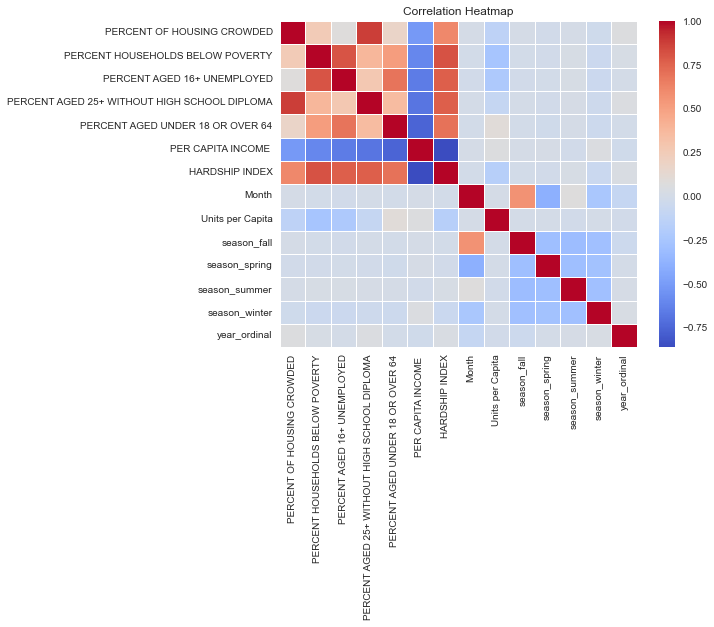

In [16]:
correlation_matrix = Xb1.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, cmap="coolwarm", fmt=".2f", linewidths=.8)

# Show the plot
plt.title("Correlation Heatmap")
plt.show()

### Train Test Split

In [17]:
print(Xb1.shape)
print(yb1.shape)
print(Xb2.shape)
print(yb2.shape)

(8646, 14)
(8646,)
(7300, 14)
(7300,)


In [18]:
#Splitting Data
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(Xb1, yb1, test_size=0.2, random_state=42)
Xb2_train, Xb2_test, yb2_train, yb2_test = train_test_split(Xb2, yb2, test_size=0.2,random_state=42)

### Evaluating Models

In [19]:
def score_model(X_train, y_train, X_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Train the model on the training set
    model.fit(X_train, y_train, **kwargs)  
    
    # Predict on the testing set
    y_test_predicted = model.predict(X_test)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    f1 = f1_score(y_test, y_test_predicted, average='weighted')
    print("{}: {}".format(estimator.__class__.__name__, f1))

In [20]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(max_iter=10000), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

print("Binary Class 75th Scores:")
for model in models:
    score_model(X_train=Xb1_train, y_train=yb1_train, X_test=Xb1_test, y_test=yb1_test, estimator=model)

print("")
print("Binary Class Mean Scores:")
for model in models:
    score_model(X_train=Xb2_train, y_train=yb2_train, X_test=Xb2_test, y_test=yb2_test, estimator=model)

Binary Class 75th Scores:
SVC: 0.8670136414250434
NuSVC: 0.8710901257973851
LinearSVC: 0.31424579431880917
SGDClassifier: 0.7048769996365692
KNeighborsClassifier: 0.8346342736091397
LogisticRegression: 0.7547655424744195
LogisticRegressionCV: 0.7460435627826076
BaggingClassifier: 0.8751819000999215
ExtraTreesClassifier: 0.852645053350958
RandomForestClassifier: 0.8653562320496271

Binary Class Mean Scores:
SVC: 0.8348637280478243
NuSVC: 0.8335023653262054
LinearSVC: 0.400787552938509
SGDClassifier: 0.7414937981943494
KNeighborsClassifier: 0.8148446774969347
LogisticRegression: 0.7727378132780688
LogisticRegressionCV: 0.7679777972762628
BaggingClassifier: 0.8260156442076422
ExtraTreesClassifier: 0.8177569144104034
RandomForestClassifier: 0.8178000128955867


### Visualizing Models

In [21]:
def visualize_model(X_train, y_train, X_test, y_test, estimator, target_names, **kwargs):
    """
    Test various estimators.
    """ 
    
    model = Pipeline([
         ('estimator', estimator)
    ])

    # Train the model on the training set
    model.fit(X_train, y_train, **kwargs)  
    
    # Predict on the testing set
    y_test_predicted = model.predict(X_test)

    # Display classification report
    report = classification_report(y_test, y_test_predicted, target_names=target_names)
    #print(report)

    # Visualize the classification report
    visualizer = ClassificationReport(
        model,
        classes=target_names,
        cmap="Reds",
        support=True,
        size=(600, 360)
    )
    visualizer.score(X_test, y_test)
    visualizer.show()

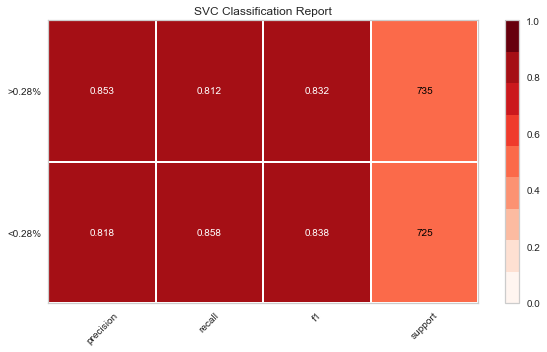

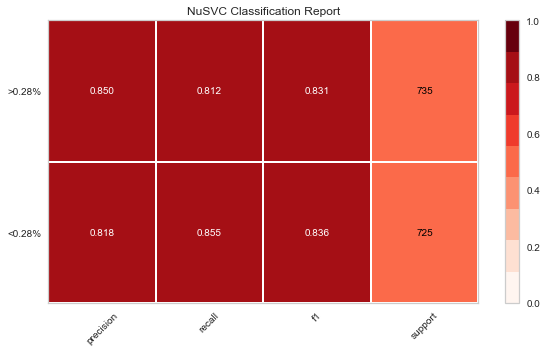

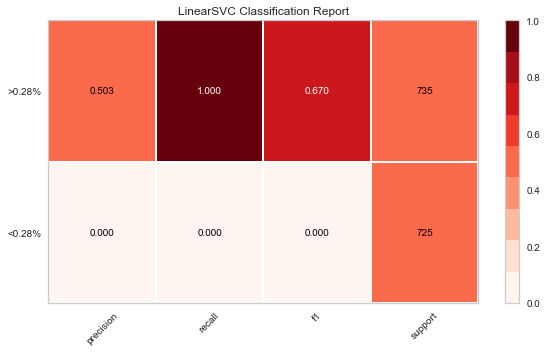

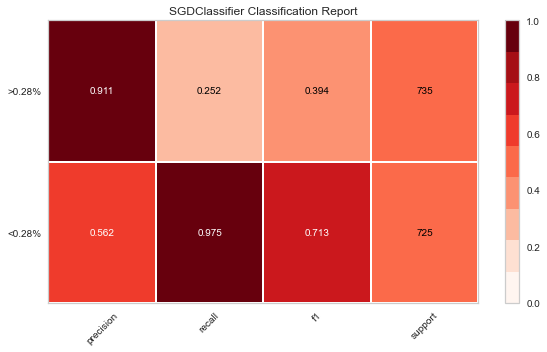

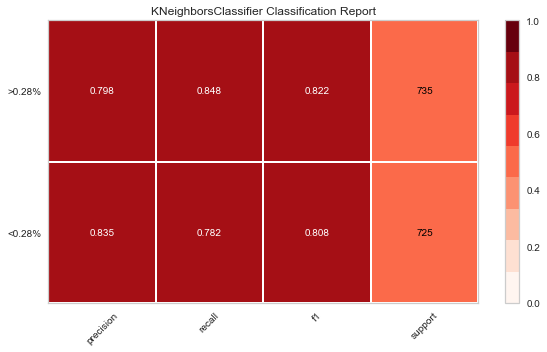

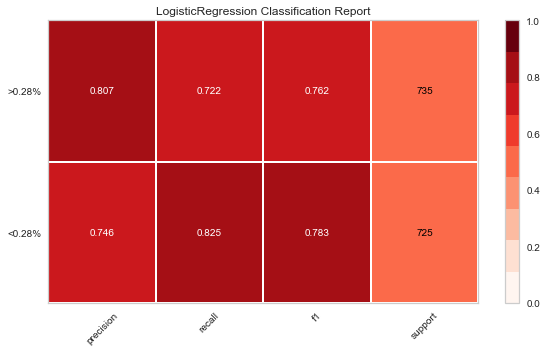

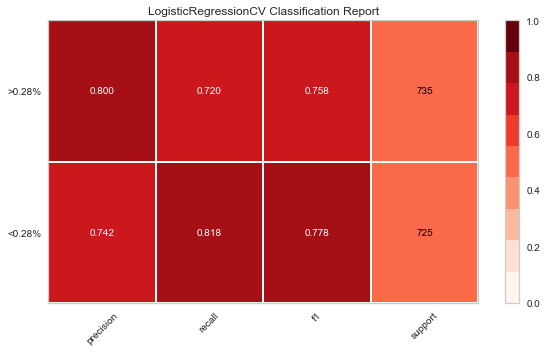

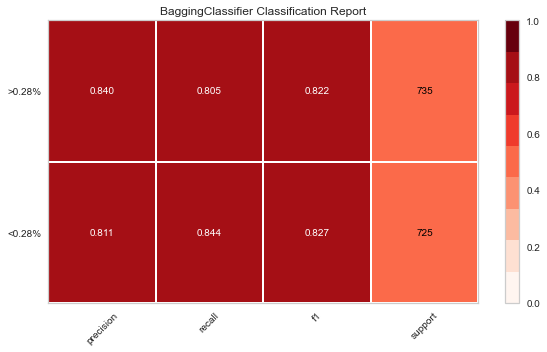

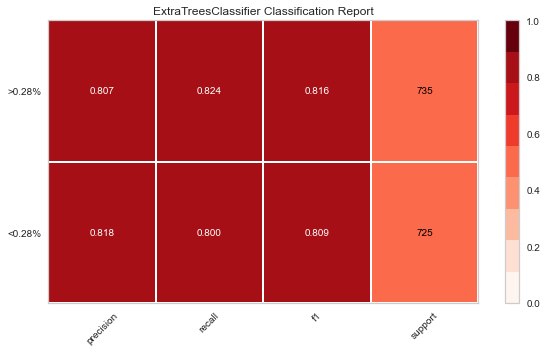

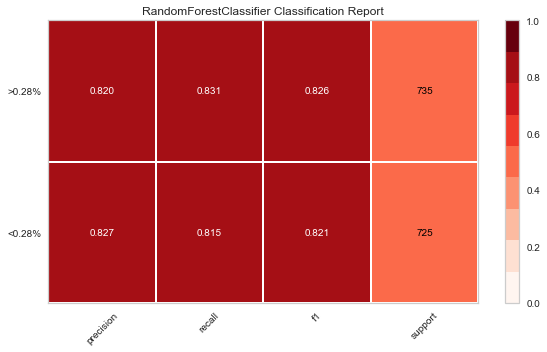

In [22]:
target_names = ['<0.28%','>0.28%']

for model in models:
    visualize_model(X_train=Xb2_train, y_train=yb2_train, X_test=Xb2_test, y_test=yb2_test, 
                    estimator=model, target_names=target_names)

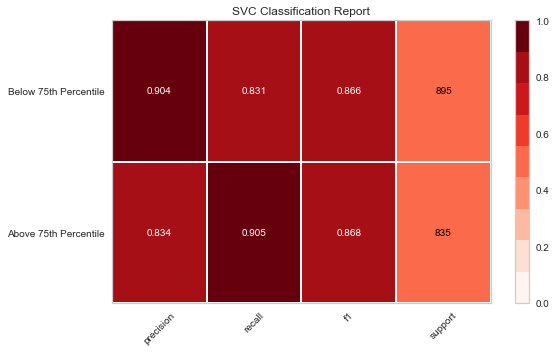

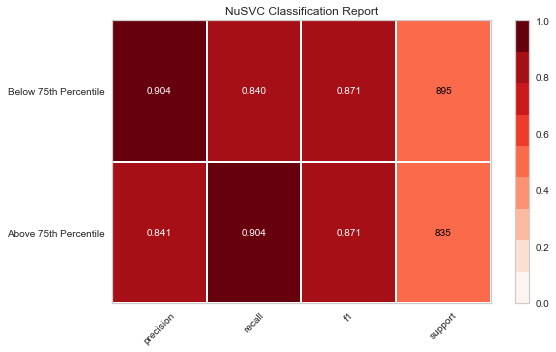

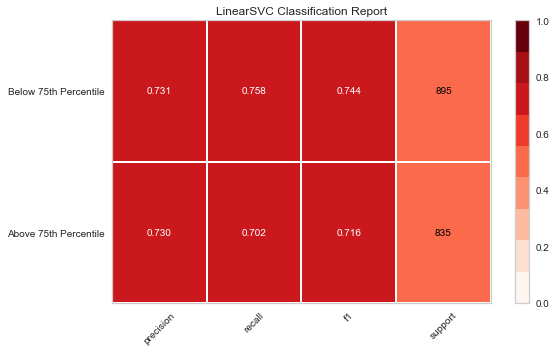

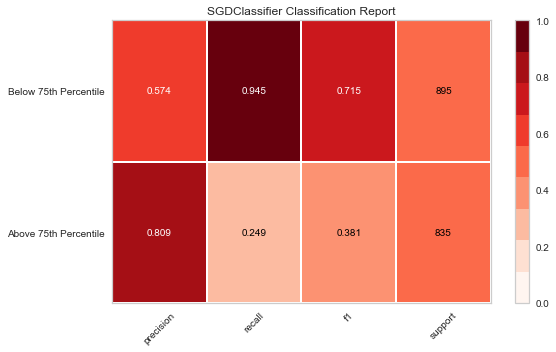

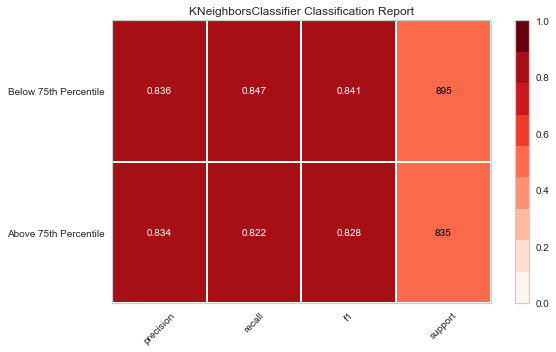

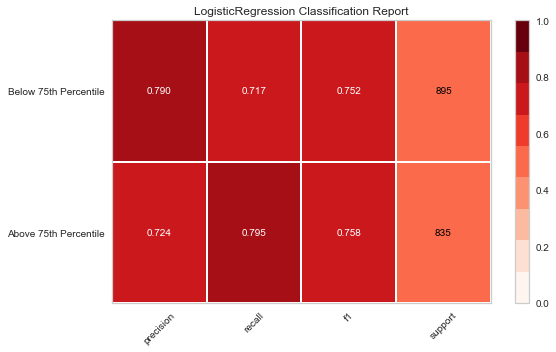

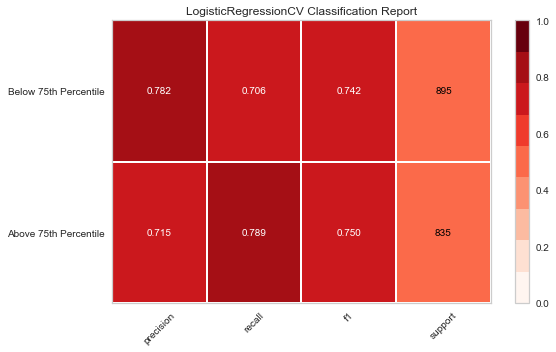

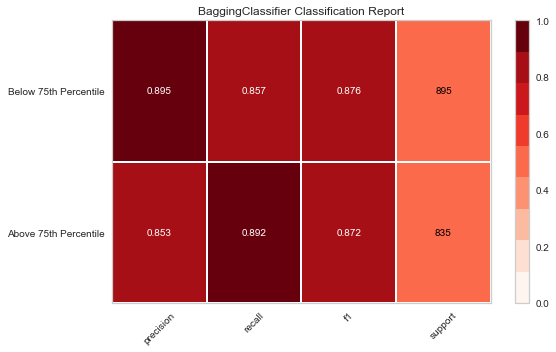

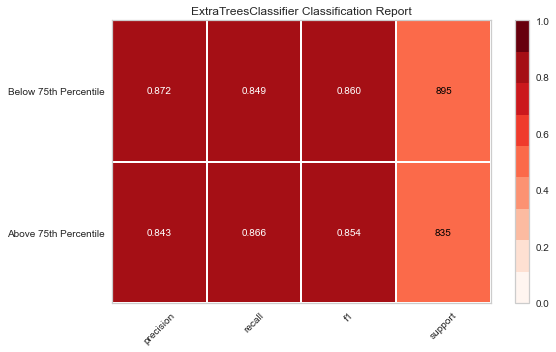

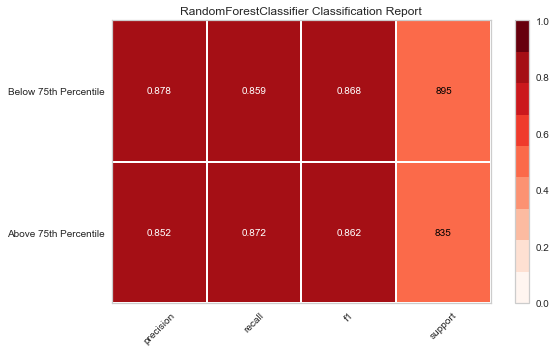

In [23]:
for model in models:
    '''target_names = ['Between 50th and 75th Percentile',
                    'Below 25th Percentile',
                    'Between 25th and 50th Percentile',
                    'Above 75th Percentile']
                    '''
    target_names = ['Above 75th Percentile','Below 75th Percentile']
            
    visualize_model(X_train=Xb1_train, y_train=yb1_train, X_test=Xb1_test, y_test=yb1_test, 
                    estimator=model, target_names=target_names)

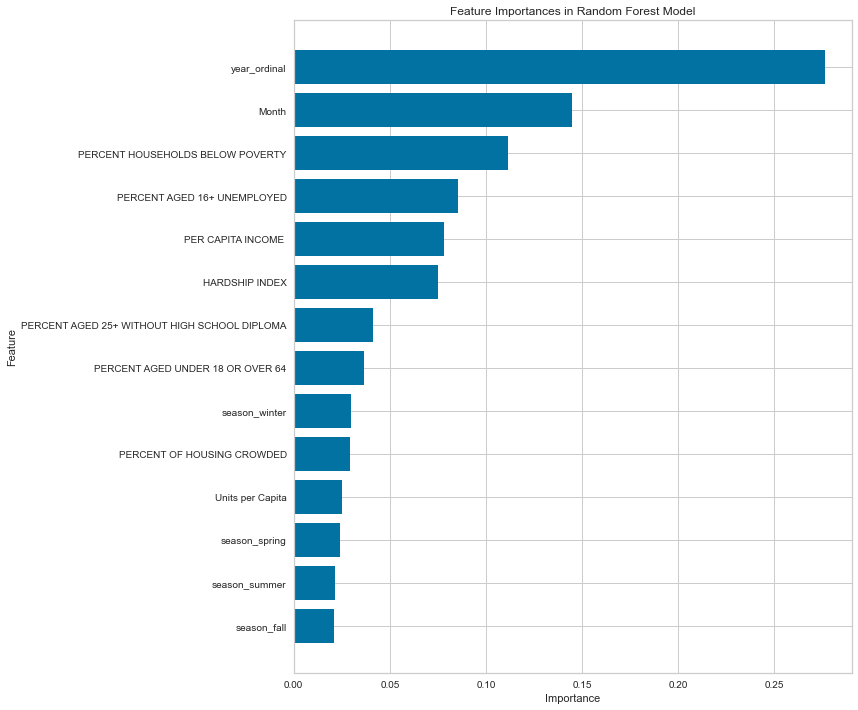

In [24]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(Xb1, yb1)

importances = rf_classifier.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': Xb1_train.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis() 
plt.show()

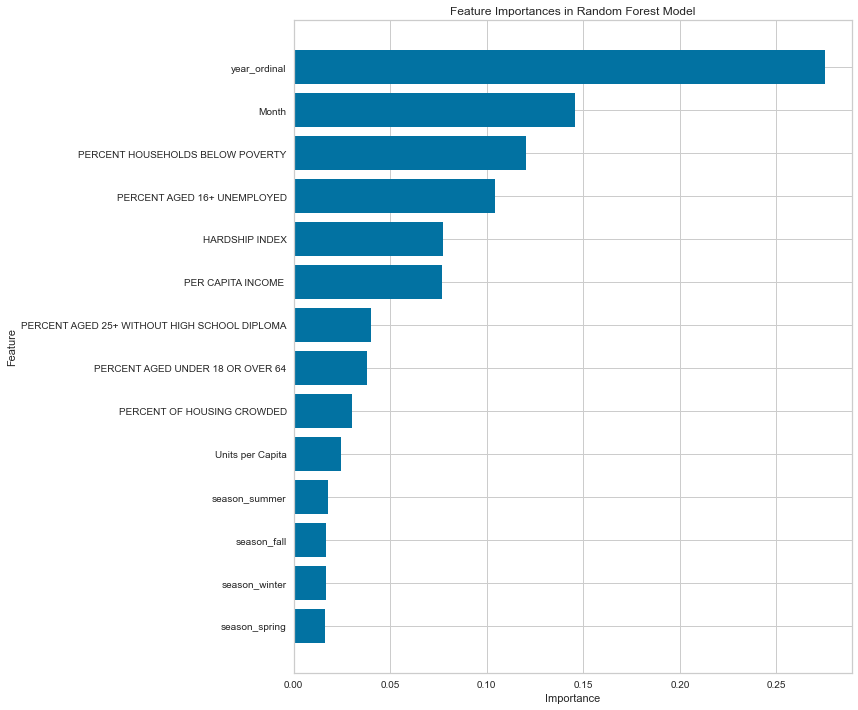

In [25]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(Xb2, yb2)

importances = rf_classifier.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': Xb2_train.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 12))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in Random Forest Model')
plt.gca().invert_yaxis() 
plt.show()